# Lesson 5 Assignment - Targeted Marketing Campaign

## Author - Kenji Oman

In this problem we will use historical data from past customer responses to build a classification model.

We will apply the trained model to a new set of prospects to whom we may want extend an offer for a [Personal Equity Plan](https://www.investopedia.com/terms/p/pep.asp). Rather than doing a mass marketing campaign to all new prospects, we would like to target those that are likely to respond positively to our offer (according to our classification model).

## Tasks
Use the provided Bank Data.csv file: 

1. Read in, parse and preprocess the data
2. Perform a brief exploratory analysis
3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model
4. Graph the structure of your decision tree
5. Graph the confusion matrix of your random forest model

# Library/ Data Loading

In [1]:
# Data set contains 600 rows and 11 columns.
URL = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/Bank%20Data.csv"

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd

import category_encoders
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
import sklearn.metrics as sklm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz

from IPython.display import display, Markdown, Image

# Set up seaborn plotting params
sns.set_style('darkgrid')

In [3]:
# Load the data
df = pd.read_csv(URL)
# and take a peak
display(df.head())
# And some summary statistics
display(df.describe(include='all'))

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
count,600.000000,600,600,600.000000,600,600.000000,600,600,600,600,600
unique,NaN,2,4,NaN,2,NaN,2,2,2,2,2
top,NaN,MALE,INNER_CITY,NaN,YES,NaN,NO,YES,YES,NO,NO
freq,NaN,300,269,NaN,396,NaN,304,414,455,391,326
mean,42.395000,NaN,NaN,27524.031217,NaN,1.011667,NaN,NaN,NaN,NaN,NaN
std,14.424947,NaN,NaN,12899.468246,NaN,1.056752,NaN,NaN,NaN,NaN,NaN
min,18.000000,NaN,NaN,5014.210000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,30.000000,NaN,NaN,17264.500000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,42.000000,NaN,NaN,24925.300000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
75%,55.250000,NaN,NaN,36172.675000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN


Across the board, we had no missing values! (yay!)  We also notice Age ranges from 18-67 (makes sense, since the PEP document said it was for people 18 and up), and the number of children range from 0-3 (I guess they don't in general have larger families than that in the UK?)

# Additional Basic EDA/ Data Cleanup
Immediately, we see that we have several binary columns, so let's convert them to ints

In [4]:
# Actually, convert them to categorical type, which are ints behind the scenes, but
# in all representations, will print what you expect
yesno = pd.api.types.CategoricalDtype(categories=['NO', 'YES'], ordered=False)
yesno_cols = ['married', 'car', 'save_act', 'current_act', 'mortgage', 'pep']
gender = pd.api.types.CategoricalDtype(categories=['MALE', 'FEMALE'], ordered=False)

df.loc[:, yesno_cols] = df.loc[:, yesno_cols].astype(yesno)
df.sex = df.sex.astype(gender)
# Now, check to make sure these were encoded as categorical types
display(df.info())

# And, make sure it still shows what we expect
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
age            600 non-null int64
sex            600 non-null category
region         600 non-null object
income         600 non-null float64
married        600 non-null category
children       600 non-null int64
car            600 non-null category
save_act       600 non-null category
current_act    600 non-null category
mortgage       600 non-null category
pep            600 non-null category
dtypes: category(7), float64(1), int64(2), object(1)
memory usage: 23.6+ KB


None

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [5]:
# Also, let's look at the dtypes of these columns, just to be safe
df.sex.dtype, df.married.dtype

(CategoricalDtype(categories=['MALE', 'FEMALE'], ordered=False),
 CategoricalDtype(categories=['NO', 'YES'], ordered=False))

In [6]:
# Looking back, it looks like region also has only 4 unique values, so
# let's take a look at what we have
df.region.value_counts()

INNER_CITY    269
TOWN          173
RURAL          96
SUBURBAN       62
Name: region, dtype: int64

## Region vs Pep, raw counts

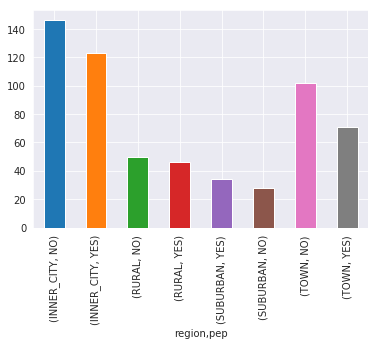

## Region vs Pep, Normalized

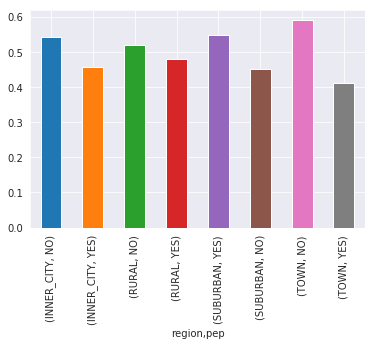

In [7]:
# Also, see how this relates to our target variable
display(Markdown('## Region vs Pep, raw counts'))
df.groupby('region').pep.value_counts().plot.bar()
plt.show()

# And, if we had normalized
display(Markdown('## Region vs Pep, Normalized'))
df.groupby('region').pep.value_counts(normalize=True).plot.bar()
plt.show()

So, it looks like Town has the most discriminating power (if someone is in a town, they are ~0.6/0.4 = 1.5 times more likely to not purchase a personal equity plan), but as we see, these are clearly categorical (not ordinal) values, so let's encode them).  Since we only have 600 entries, let's not dummy encode (aka, one-hot encoding), which will give us 13 total features), but instead, let's try a target encoding approach mentioned [here on slides 21-38](https://www.slideshare.net/0xdata/feature-engineering-83511751), and [here (original paper)](https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf), as implemented as a part of the [category_encoders module](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html) ([original feature post in git](https://github.com/scikit-learn-contrib/categorical-encoding/pull/45)).  Since we want to try to estimate our accuracy via cross-validation, we need to do the endcoding of "Region" on the fly with each split of our CV.

Also, let's do standard encoding of age, income, and children features as well (once again, as a part of the cross validation)

# Estimate Accuracy
## Prep Work

In [8]:
# First, we need to convert our category columns (Yes/Now, Male/Female) to their corresponding numerical
# codes
ml_df = df.copy()
cat_cols = ml_df.select_dtypes('category').columns
ml_df.loc[:, cat_cols] = ml_df.loc[:, cat_cols].apply(lambda x: x.cat.codes)
ml_df.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,1,INNER_CITY,17546.0,0,1,0,0,0,0,1
1,40,0,TOWN,30085.1,1,3,1,0,1,1,0
2,51,1,INNER_CITY,16575.4,1,0,1,1,1,0,0
3,23,1,TOWN,20375.4,1,3,0,0,1,0,0
4,57,1,RURAL,50576.3,1,0,0,1,0,0,0


In [9]:
# Define running of a classifier through cross-validation
def run_CV(clf):
    # Define a k-fold cross validation
    kf = StratifiedKFold(n_splits=5, random_state=10)
    
    # Initialize the storing of our accuracy scores
    scores = []
    
    # And Create a loop to go through the different folds
    for train_index, test_index in kf.split(ml_df.drop(columns='pep'), ml_df.pep):
        
        # now, grab the train/ test data
        train_df = ml_df.iloc[train_index].copy()
        test_df = ml_df.iloc[test_index].copy()
        
        # Now, run target encoder on the region feature. First, initialize
        target_encoder = category_encoders.target_encoder.TargetEncoder(cols=['region'])
        
        # Now, fit/transform to the training data
        train_df.region = target_encoder.fit_transform(train_df.drop(columns='pep'), train_df.pep).region
        # Also, transform the test data
        test_df.region = target_encoder.transform(test_df.drop(columns='pep')).region
        
        # Now, apply the standard scalar to the remaining columns
        # First, initialize the standard scalar
        stdscaler = StandardScaler()
        
        # Now, fit on the remaining columns
        train_df.loc[:, ['age', 'income', 'children']] = stdscaler.fit_transform(
            train_df.loc[:, ['age', 'income', 'children']])
        # Also, transform the test data
        test_df.loc[:, ['age', 'income', 'children']] = stdscaler.transform(
            test_df.loc[:, ['age', 'income', 'children']])
        
        # Now, train the classifier
        clf.fit(train_df.drop(columns='pep'), train_df.pep)
        
        # And make predictions on the test data
        pred_y = clf.predict(test_df.drop(columns='pep'))
        
        # Now, keep the accuracy metric
        scores.append(sklm.accuracy_score(test_df.pep, pred_y))
        
    return scores

## Decision Tree vs Random Forest Accuracy

In [10]:
# Now, apply the function to  decision tree, and random forest classifiers
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=10)
rf = RandomForestClassifier(criterion='entropy', random_state=10)
dt_scores = run_CV(dt)
rf_scores = run_CV(rf)

# And give their output
display(Markdown('### Average Decision Tree Accuracy'))
print('{:.2f}%'.format(np.mean(dt_scores)*100))
display(Markdown('### Average Random Forest Accuracy'))
print('{:.2f}%'.format(np.mean(rf_scores)*100))

### Average Decision Tree Accuracy

83.84%


### Average Random Forest Accuracy

84.00%


We see from the above that, with no hyperparameter tuning (default settings), the random forests model performs slightly better than the single decision tree, which makes sense, since RF is more robust to over-fitting.

# Decision Tree Graph

In [11]:
# Now, make a graph of the decision Tree. First, let's just fit
# the decision tree on the entire dataset. Before that, need to scale our features
target_encoder = category_encoders.target_encoder.TargetEncoder(cols=['region'])
        
# Now, fit/transform the region column
ml_df.region = target_encoder.fit_transform(ml_df.drop(columns='pep'), ml_df.pep).region

# Also, do standard scaling on the continuous columns
stdscaler = StandardScaler()
ml_df.loc[:, ['age', 'income', 'children']] = stdscaler.fit_transform(
    ml_df.loc[:, ['age', 'income', 'children']])

# Now, fit to this data
dt.fit(ml_df.drop(columns='pep'), ml_df.pep)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

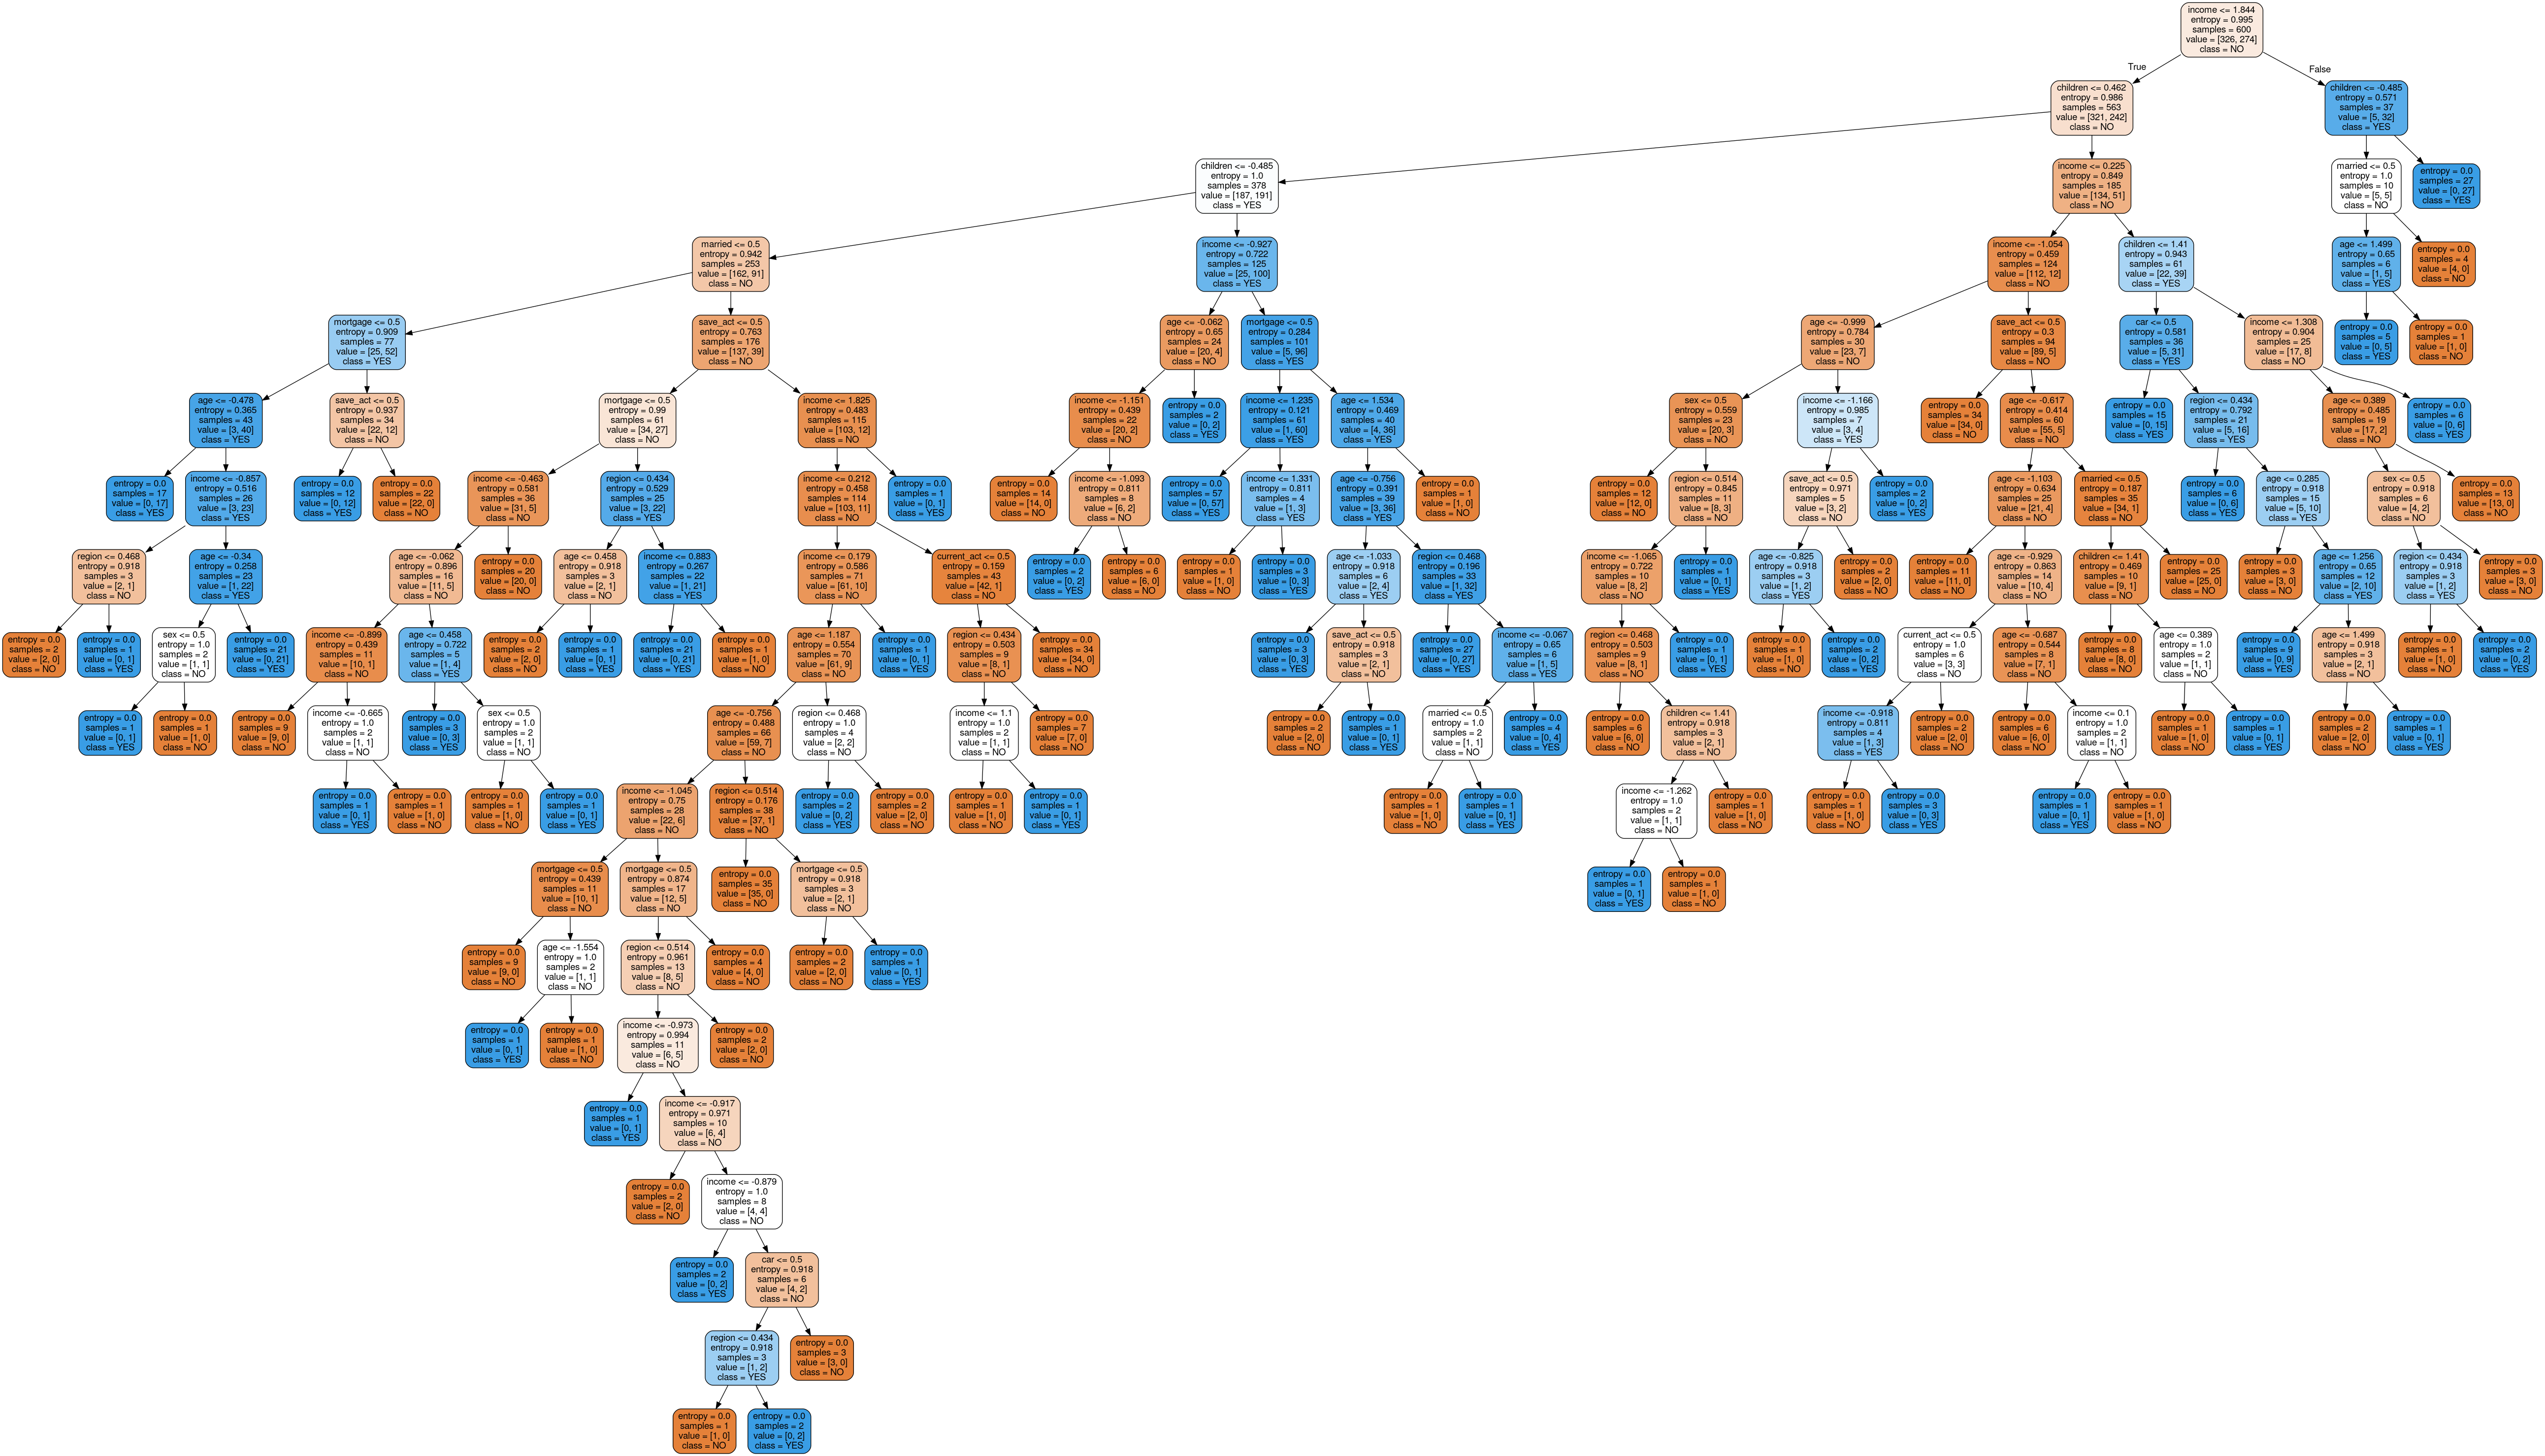

In [12]:
# Now, visualize the decisions
tree.export_graphviz(dt, out_file='KenjiOman-L05-DecisionTree.dot', filled=True, rounded=True, feature_names=df.drop(columns='pep').columns,
                     class_names=['NO', 'YES'])
os.system("dot -Tpng KenjiOman-L05-DecisionTree.dot -o KenjiOman-L05-DecisionTree.png")
Image('KenjiOman-L05-DecisionTree.png')

We notice above that the decision tree is quite complex -- if we had more time, perhaps we could work on pruning the tree down some, which might even get better performance (help fight against over-fitting).  But, for now, let's just look at the confusion matrix of the random forest model

# Random Forest Confusion Matrix

In [13]:
# Once again, we need to fit our random forest model. Since we are
# making a confusion matrix, let's do a train/test split first.
# But, before we do that, let's create another ml_df (can't use the other,
# since some encoding already happened)
ml_df = df.copy()
cat_cols = ml_df.select_dtypes('category').columns
ml_df.loc[:, cat_cols] = ml_df.loc[:, cat_cols].apply(lambda x: x.cat.codes)

# Now, apply the train/test split
train_df, test_df = train_test_split(ml_df, test_size=0.2, random_state=10)

# Now, do the scaling of the features on the training data
train_df.loc[:, 'region'] = target_encoder.fit_transform(train_df.drop(columns='pep'), train_df.pep).region

# Also, do standard scaling on the continuous columns
stdscaler = StandardScaler()
train_df.loc[:, ['age', 'income', 'children']] = stdscaler.fit_transform(
    train_df.loc[:, ['age', 'income', 'children']])

# And, now do the same encoding/ scalings on the test data
test_df.region = target_encoder.transform(test_df.drop(columns='pep'), test_df.pep).region
test_df.loc[:, ['age', 'income', 'children']] = stdscaler.transform(
    test_df.loc[:, ['age', 'income', 'children']])

/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
# Now, fit the model
rf.fit(train_df.drop(columns='pep'), train_df.pep)

# And make predictions
predict = rf.predict(test_df.drop(columns='pep'))
predict

# And tie them to the actual results
results = test_df.pep.rename('actual').to_frame()
results['predicted'] = predict
results.head()

,actual,predicted
69,1,0
27,1,1
488,0,0
540,1,1
285,0,0


In [15]:
# Now, make the confusion matrix
RF_cm = pd.DataFrame(sklm.confusion_matrix(results.actual, results.predicted),
                     index=['Actual_PEP_No', 'Actual_PEP_Yes'],
                     columns=['Predict_PEP_No', 'Predict_PEP_Yes'])
RF_cm

,Predict_PEP_No,Predict_PEP_Yes
Actual_PEP_No,49,8
Actual_PEP_Yes,12,51


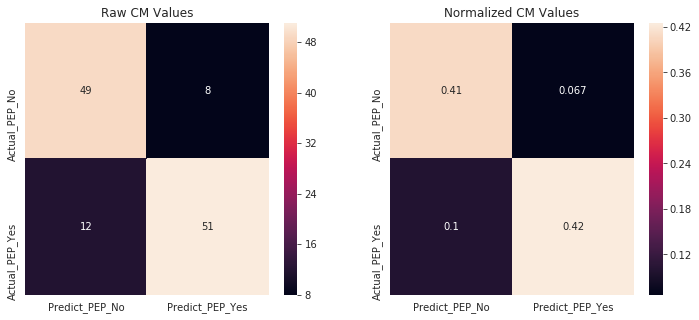

In [16]:
# And finally, visualize it
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
sns.heatmap(RF_cm, annot=True, ax=ax)
plt.title('Raw CM Values')
ax = f.add_subplot(122)
sns.heatmap(RF_cm/RF_cm.sum().sum(), annot=True, ax=ax)
plt.title('Normalized CM Values')
plt.show()

We see that for this random forest (trained on this specific subset of the data), we get an accuracy of 83% (sum of the white diagonal cells).  Not bad for a basic implementation, but we could next work to try to optimize the hyperparameters a bit, or perhaps try other encoding methods or feature scalings.